In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Importing Data : 
* Data is imported from a different source as the original dataset contains comments in languages other than english as well and since we are implementing Logistic Regression with lots of feature engineering, it is better to work with a uniform and consistent data. 


In [2]:
train1  = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv").dropna()
train2 = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv").dropna()
valid = pd.read_csv('../input/jigsaw-translate-en/validation_en.csv')
test = pd.read_csv('../input/jigsaw-translate-en/test_en.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
print("Number of data points in training set 1: ", train1.shape[0])
print("Number of data points in training set 2: ", train2.shape[0])
print("Number of data points in total training set 1: ", (train1.shape[0]+train2.shape[0]))
print("Number of data points in validation set: ", valid.shape[0])
print("Number of data points in test set : ", test.shape[0])


Number of data points in training set 1:  223549
Number of data points in training set 2:  247396
Number of data points in total training set 1:  470945
Number of data points in validation set:  8000
Number of data points in test set :  63812


In [3]:
print([print('{} \n'.format(i)) for i in train2.comment_text[(train2.toxic>0.4) & (train2.toxic <0.5)][:7]])

This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it. 

Get a better dictionary.  You are a bigot,   All the little quibbles about whether someone spelled "minuscule" correctly, or whether homophobia means  "fear" of  John is just your way of denying your bigotry.. 

So who gets to be the genital checker? You? So because you had a bad experience with one transgender person compared to the likely dozens of times you had no problem whatsoever using the bathroom with trans people, they now have no place in this world? Get over yourself, theres room enough here for everyone, even the people you don't like. 

At no time do you ever have anything remotely intelligent to offer public debate. That would require intelligence. neither do you know how to be a man, and man up when your ignorance is addressed with irrefutable fact. That would require character. What a daft deluded fool like you fails to understand is the fact you are the political t

- As we can see that comments with a toxicity score of more than 0.4 but less than 0.5 can also be considered as toxic, It might be wise to set the threshold to >0.4 or >0.35 when we are rounding it off to 0 or 1 for a classification problem. 

In [4]:
train2.toxic = train2.toxic.apply(lambda x: 1 if x>0.4 else 0)
valid = valid.drop(columns = ['comment_text', 'id', 'lang'])
test = test.drop(columns = ['content', 'id', 'lang'])
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']]
])


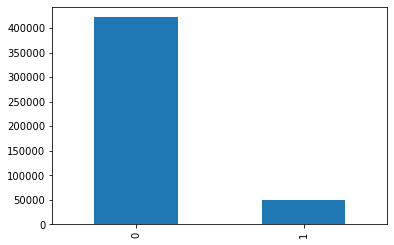

In [5]:
train.toxic.value_counts().plot(kind = 'bar')

- We can observe from the plot above that there is a significant class imbalance between toxic and non toxic comments in our training dataset.


## Undersampling:
- since there is a significant difference between toxic and non-toxic comments, it makes sense to undersample our model to not be susceptible to any bias 

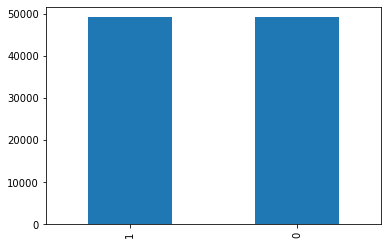

In [6]:
from sklearn.utils import resample
toxic = train[train.toxic ==1]
not_toxic = train[train.toxic == 0]

downsampled = resample(not_toxic,
                       replace = False, # sample without replacement
                       n_samples = len(toxic), # match minority n
                       random_state = 10) # reproducible results
train = pd.concat([downsampled, toxic])
train.toxic.value_counts().plot(kind = 'bar')

In [7]:
x_train = train['comment_text']
x_valid = valid['content_en']
x_test = test['content_en']
y_train = train['toxic']
y_valid = valid['toxic']

In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
preprocessed_comments_train = []
# tqdm is for printing the status bar
for sentance in tqdm(x_train.values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_comments_train.append(sentance.strip())

preprocessed_comments_valid = []
# tqdm is for printing the status bar
for sentance in tqdm(x_valid.values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_comments_valid.append(sentance.strip())

preprocessed_comments_test = []
# tqdm is for printing the status bar
for sentance in tqdm(x_test.values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_comments_test.append(sentance.strip())


100%|██████████| 63812/63812 [00:32<00:00, 1935.28it/s]


### BagOfWords :

In [9]:
# We are considering only the words which appeared in at least 10 comments .
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_comments_train)
x_train_comments_bow = vectorizer.transform(preprocessed_comments_train)
x_valid_comments_bow = vectorizer.transform(preprocessed_comments_valid)
x_test_comments_bow = vectorizer.transform(preprocessed_comments_test)

feature_names_comments_bow_one_hot = vectorizer.get_feature_names()
print("Shape of matrix after one hot encodig ",x_train_comments_bow.shape)
print("Shape of matrix after one hot encodig ",x_valid_comments_bow.shape)
print("Shape of matrix after one hot encodig ",x_test_comments_bow.shape)

Shape of matrix after one hot encodig  (98300, 16632)
Shape of matrix after one hot encodig  (8000, 16632)
Shape of matrix after one hot encodig  (63812, 16632)


### TFIDF :

In [10]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit_transform(preprocessed_comments_valid)
x_train_tfidf_comment = vectorizer.transform(preprocessed_comments_train)
x_valid_tfidf_comment = vectorizer.transform(preprocessed_comments_valid)
x_test_tfidf_comment = vectorizer.transform(preprocessed_comments_test)
feature_names_tfidf_comment = vectorizer.get_feature_names()
print("Shape of matrix after one hot encodig ",x_train_tfidf_comment.shape)
print("Shape of matrix after one hot encodig ",x_valid_tfidf_comment.shape)
print("Shape of matrix after one hot encodig ",x_test_tfidf_comment.shape)

Shape of matrix after one hot encodig  (98300, 3035)
Shape of matrix after one hot encodig  (8000, 3035)
Shape of matrix after one hot encodig  (63812, 3035)
CPU times: user 9.06 s, sys: 16.6 ms, total: 9.08 s
Wall time: 9.08 s


### Training the w2v Model with X_train

In [11]:
def cleanPunctuation(sentence):                   #https://stackoverflow.com/questions/13237533/find-different-realization-of-a-word-in-a-sentence-string-python   
    exclude = set(string.punctuation)
    return ''.join(ch for ch in sentence if ch not in exclude)

from bs4 import BeautifulSoup
i = 0 
list_of_sent = []
for sent1 in tqdm(preprocessed_comments_train):
    filtered_sent = []
    soup = BeautifulSoup(sent1, 'html.parser')
#     soup_packtpage = BeautifulSoup(sent,"html.parser")
    sentt = soup.get_text()
    for w in sentt.split():
        for clean_words in cleanPunctuation(w).split():
            filtered_sent.append(clean_words.lower())
        else:
            continue
    list_of_sent.append(filtered_sent)

100%|██████████| 98300/98300 [00:23<00:00, 4249.56it/s]


In [12]:
%%time
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent, min_count=10,size=50,workers=-1)

CPU times: user 8.51 s, sys: 55.2 ms, total: 8.57 s
Wall time: 8.56 s


### Average w2v on comments :

In [13]:
x_train_avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/comment is stored in this list
glove_words = set(w2v_model.wv.vocab)
for sentence in tqdm(preprocessed_comments_train): # for each comment/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of wordswith a valid vector in the sentence/comment  
    for word in sentence.split(): # for each word in a comment 
        if word in glove_words:
            vector += w2v_model.wv[word]
            cnt_words += 1
        else:
            pass
    if cnt_words != 0:
        vector /= cnt_words
    x_train_avg_w2v_vectors_essay.append(vector)

print(len(x_train_avg_w2v_vectors_essay))
print(len(x_train_avg_w2v_vectors_essay[0]))

100%|██████████| 98300/98300 [00:17<00:00, 5646.27it/s]

98300
50


In [14]:
x_valid_avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/comment is stored in this list
glove_words = set(w2v_model.wv.vocab)
for sentence in tqdm(preprocessed_comments_valid): # for each comment/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of wordswith a valid vector in the sentence/comment  
    for word in sentence.split(): # for each word in a comment 
        if word in glove_words:
            vector += w2v_model.wv[word]
            cnt_words += 1
        else:
            pass
    if cnt_words != 0:
        vector /= cnt_words
    x_valid_avg_w2v_vectors_essay.append(vector)

print(len(x_valid_avg_w2v_vectors_essay))
print(len(x_valid_avg_w2v_vectors_essay[0]))

100%|██████████| 8000/8000 [00:01<00:00, 5710.64it/s]

8000
50


In [15]:
x_test_avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/comment is stored in this list
glove_words = set(w2v_model.wv.vocab)
for sentence in tqdm(preprocessed_comments_test): # for each comment/sentence
    vector = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of wordswith a test vector in the sentence/comment  
    for word in sentence.split(): # for each word in a comment 
        if word in glove_words:
            vector += w2v_model.wv[word]
            cnt_words += 1
        else:
            pass
    if cnt_words != 0:
        vector /= cnt_words
    x_test_avg_w2v_vectors_essay.append(vector)

print(len(x_test_avg_w2v_vectors_essay))
print(len(x_test_avg_w2v_vectors_essay[0]))

100%|██████████| 63812/63812 [00:11<00:00, 5530.32it/s]

63812
50


## Stacking up feature Vectors:

In [16]:
# from numpy import hstack 
from scipy.sparse import hstack

x_train_stack = hstack([
    x_train_comments_bow, 
    x_train_tfidf_comment, 
    x_train_avg_w2v_vectors_essay
])


x_valid_stack = hstack([
    x_valid_comments_bow, 
    x_valid_tfidf_comment, 
    x_valid_avg_w2v_vectors_essay
])


x_test_stack = hstack([
    x_test_comments_bow, 
    x_test_tfidf_comment, 
    x_test_avg_w2v_vectors_essay
])


# Applying Logistic Regression:

In [17]:
# https://stackoverflow.com/a/44149119
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ROC_CM(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
#     print('Train Confusion Matrix:')
#     print(cm_train)

    fig = plt.figure(figsize=(15,13))
    ax = fig.add_subplot(221)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
#     print('Test Confusion Matrix:')
#     print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(222)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)

    df_cm_train = pd.DataFrame(cm_train, index = [i for i in ["True Positive","False Positive"]],
                         columns = [i for i in ["False Negative", "True Negative"]])
    ax3 = fig.add_subplot(223)
    plt.title("Train Confusion Matrix")
    sns.heatmap(df_cm_train, annot=True,fmt="d")
    df_cm_test = pd.DataFrame(cm_test, index = [i for i in ["True Positive","False Positive"]],
                         columns = [i for i in ["False Negative", "True Negative"]])
    ax3 = fig.add_subplot(224)
    
    plt.title("Test Confusion Matrix")
    sns.heatmap(df_cm_test, annot=True,fmt="d")
    
    plt.show()
    
    return best_threshold
# ROC_CM(Y_train, Y_train_pred, Y_test, Y_test_pred)

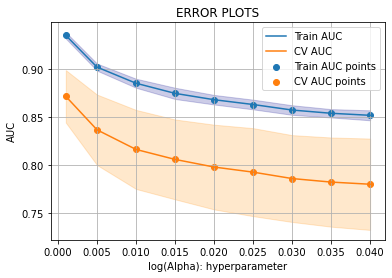

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier


classifier = SGDClassifier(loss = 'log',class_weight='balanced')
parameters = {'alpha':[0.001,0.005, 0.01, 0.015, 0.020, 0.025, .030, 0.035, 0.040]} 
clf = GridSearchCV(classifier, 
                   parameters, 
                   cv=3, 
                   scoring='roc_auc',
                   return_train_score=True)
clf.fit(x_train_stack, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(Alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

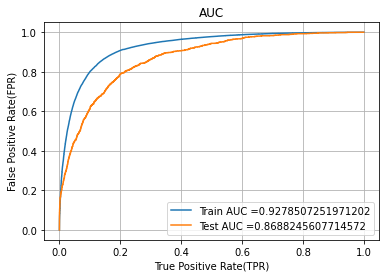

In [19]:
best_alpha = clf.best_params_['alpha']
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

LR = SGDClassifier(loss = 'log',alpha = best_alpha)

LR.fit(x_train_stack, y_train)
# roc_auc_score(Y_true, Y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Y_train_pred = batch_predict(LR, x_train_stack)    
# Y_test_pred = batch_predict(LR, x_cv_stack)

Y_train_pred = LR.predict_proba(x_train_stack)    
Y_valid_pred = LR.predict_proba(x_valid_stack)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, Y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_valid, Y_valid_pred[:,1])

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()



Train Accuracy: 0.8595015259409969 
Train AUC: 0.8595015259409969 
Test Accuracy: 0.854375 
Test AUC: 0.7622707785423498 


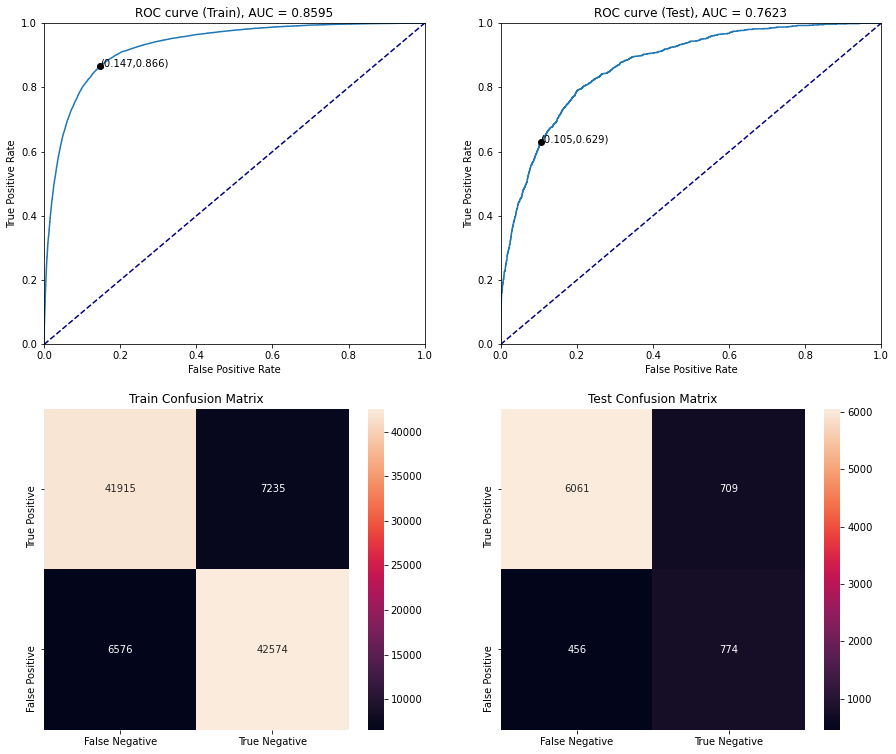

0.46758206507992345

In [20]:
ROC_CM(y_train, Y_train_pred[:,1],y_valid, Y_valid_pred[:,1])

- As we can see that a simple linear regression model with very miniscule hyperparamater tuning results in significantly satisfactory results. 

In [21]:
submission_predictions = LR.predict_proba(x_test_stack)
sub['toxic'] = submission_predictions[:,1]
sub.to_csv('submission.csv', index=False)
